# NLP with Tensorflow

Working on the Spam Classification dataset from kaggle. We will perform Basic NLP processes using Tensorflow.

## Data Cleansing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *

In [2]:
df = pd.read_csv('dataset/spam_email_raw_text.csv')
df.drop(columns = ['FILE_NAME'], inplace = True)
df.head()

,CATEGORY,MESSAGE
0,1,"Dear Homeowner,\n\n \n\nInterest Rates are at ..."
1,1,ATTENTION: This is a MUST for ALL Computer Use...
2,1,This is a multi-part message in MIME format.\n...
3,1,IMPORTANT INFORMATION:\n\n\n\nThe new domain n...
4,1,This is the bottom line. If you can GIVE AWAY...


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5796 entries, 0 to 5795
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   CATEGORY  5796 non-null   int64 
 1   MESSAGE   5796 non-null   object
dtypes: int64(1), object(1)
memory usage: 90.7+ KB


In [4]:
df.CATEGORY.value_counts()

0    3900
1    1896
Name: CATEGORY, dtype: int64

In [5]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, random_state = 42, stratify = df.CATEGORY)
train.reset_index(inplace = True, drop = True)
test.reset_index(inplace = True, drop = True)

In [6]:
# initializing some parameters
params = {}
params['vocab_size'] = 10000
params['oov_tok'] = "<OOV>"
params['max_length'] = 200
params['padding_type'] = 'pre'
params['trunc_type'] = 'post'
params['embedding_dim'] = 20

In [7]:
tokenizer = Tokenizer(num_words = params['vocab_size'], oov_token = params['oov_tok'])
tokenizer.fit_on_texts(train.MESSAGE)
word_index = tokenizer.word_index

In [8]:
train_sequences = tokenizer.texts_to_sequences(train.MESSAGE)
train_padded = pad_sequences(train_sequences, maxlen = params['max_length'], padding = params['padding_type'], 
                             truncating = params['trunc_type'])

test_sequences = tokenizer.texts_to_sequences(test.MESSAGE)
test_padded = pad_sequences(test_sequences, maxlen = params['max_length'], padding = params['padding_type'], 
                            truncating = params['trunc_type'])

# Model Training

In [9]:
# building the neural network
model = Sequential([
    Embedding(params['vocab_size'], params['embedding_dim'], input_length = params['max_length']),
    GlobalAveragePooling1D(),
    Dense(32, activation = 'relu'),
    Dense(1, activation = 'sigmoid')
])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 20)           200000    
                                                                 
 global_average_pooling1d (G  (None, 20)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 32)                672       
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 200,705
Trainable params: 200,705
Non-trainable params: 0
_________________________________________________________________
None


In [10]:
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
history = model.fit(
    train_padded, train.CATEGORY, epochs = 20, 
    validation_data = (test_padded, test.CATEGORY),
    verbose = 0
)

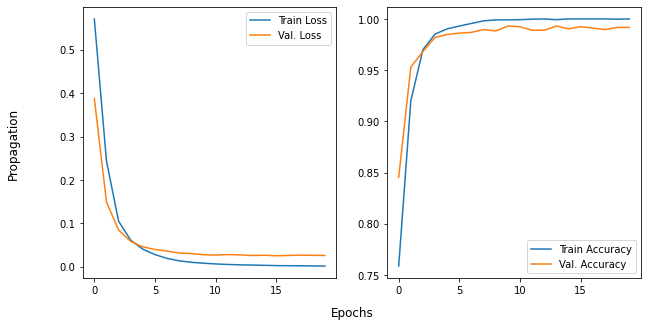

In [11]:
# plotting the results
def plot_graphs(history):
    fig, axes = plt.subplots(1, 2, figsize = (10, 5))
    axes[0].plot(history.history['loss'], label = 'Train Loss')
    axes[0].plot(history.history['val_loss'], label = 'Val. Loss')
    axes[1].plot(history.history['accuracy'], label = 'Train Accuracy')
    axes[1].plot(history.history['val_accuracy'], label = 'Val. Accuracy')
    axes[0].legend(loc = 'best')
    axes[1].legend(loc = 'best')
    fig.supxlabel('Epochs')
    fig.supylabel('Propagation')
    plt.show()

plot_graphs(history)

## Saving model and tokenizer

In [12]:
import json
model.save('tf_model.h5')
tf_tokenizer = tokenizer.to_json()
fid1 = open('tf_tokenizer.json', 'w')
fid2 = open('tf_params.json', 'w')
json.dump(tf_tokenizer, fid1)
json.dump(params, fid2)
fid1.close()
fid2.close()